In [12]:
import sys
sys.path.append("..")

# Example Alignment on Spatiotemporal Mouse Embryo

We provide an example alignment on two spatiotemporal mouse embryo slices -- `E9.5` and `E10.5` -- from Chen et al '22 (link: https://pubmed.ncbi.nlm.nih.gov/35512705/).

In particular, we show the alignment of `MGW` on the public `E9.5_E1S1.MOSTA.h5ad` and `E10.5_E1S1.MOSTA.h5ad` files.

In [13]:
# ============================================================
# M-GW: Pairwise Alignment of Spatiotemporal Mouse Embryo Slices
# ============================================================

import scanpy as sc
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import util, models, plotting, geometry
from mgw import pullback_metric_field, knn_graph
from mgw.gw import solve_gw_ott
import importlib
import matplotlib.pyplot as plt
import os

# ----------------------------
# Runtime & device setup
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Input files & parameters
# ----------------------------
filehandles_embryo_adata = [
    '/scratch/gpfs/ph3641/mouse_embryo/E9.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E10.5_E1S1.MOSTA.h5ad'
]
timepoints = ['E9.5', 'E10.5']

# Embedding / network parameters
PCA_comp   = 30
knn_k      = 12
geodesic_eps = 0.00001

gw_params = dict(verbose=True, inner_maxit=3000, outer_maxit=3000,
                 inner_tol=1e-7, outer_tol=1e-7, epsilon=1e-4)

save_dir = "/scratch/gpfs/ph3641/mgw/ME_Alignments"
os.makedirs(save_dir, exist_ok=True)

# ============================================================
# 1. Load datasets and prepare
# ============================================================
print('Loading AnnData slices...')
adatas = []
for i, fh in enumerate(filehandles_embryo_adata):
    adata = sc.read_h5ad(fh)
    adata.X = adata.layers['count']
    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]
    adatas.append(adata)

# Intersect genes across all slices
common_genes = list(set.intersection(*[set(a.var_names) for a in adatas]))
adatas = [a[:, common_genes] for a in adatas]
print(f"Common genes: {len(common_genes)}")


Device: cuda
Loading AnnData slices...
Common genes: 24040


In [14]:
from mgw import metrics
from mgw import mgw as mgw
from scipy.spatial.distance import cdist

ad1, ad2 = adatas[0], adatas[1]
tp1, tp2 = timepoints[0], timepoints[1]

print(f"\n--- Aligning {tp1} → {tp2} ---")

# Normalization, log1p, PCA
joint = ad.concat([ad1, ad2], join='inner')

sc.pp.normalize_total(joint)
sc.pp.log1p(joint)
sc.pp.pca(joint, n_comps=PCA_comp)

# Split back into slices
A = joint[joint.obs['timepoint'] == tp1].copy()
B = joint[joint.obs['timepoint'] == tp2].copy()

# ========================================================
# (a) Feature preprocessing (PCA + CCA "feeler")
# ========================================================

pre = mgw.mgw_preprocess(
        A, B,
        PCA_comp=30,
        CCA_comp=3,
        use_cca_feeler=True,
        use_pca_X=True,
        use_pca_Z=True,
        log1p_X=False,
        log1p_Z=False,
        verbose=True,
        feature_only=True,
        spatial_only=False
)



--- Aligning E9.5 → E10.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[mgw.pre] PCA/raw shapes: X=(5913, 30)  Z=(18408, 30)
[mgw.pre] CCA feeler: PCA → small GW (fused) → barycentric → CCA
Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
Feature shapes -> X: (5913, 30) Z: (18408, 30)
Feeler GW sizes: X-side 5913, Z-side 8000
Solving feeler feature alignment.
Computing CCA Components
CCA dims: 3  (applied to full sets)


In [15]:
PCA_component = 30
CCA_component = 3

PHI_ARC = (128,256,256,128)
KNN_K= 12
DEFAULT_GW_PARAMS = dict(verbose=True, inner_maxit=3000, outer_maxit=3000, inner_tol=1e-7,   outer_tol=1e-7,   epsilon=1e-4)
DEFAULT_LR = 1e-3
DEFAULT_EPS = 1e-5
DEFAULT_ITER = 20_000


In [16]:
EXP_PATH = "../experiments/" #specify the path to save your trained phi psi model 
EXP_TAG = f'ME_CCA' #specify the name of your experiment

[mgw.core] device=cuda dtype=torch.float64
[mgw.core] dims: E=2, F_M=3, F_N=3
[mgw.core] training φ, ψ
[train_phi] step=1000 loss=0.197027
[train_phi] step=2000 loss=0.123135
[train_phi] step=3000 loss=0.102410
[train_phi] step=4000 loss=0.090502
[train_phi] step=5000 loss=0.081530
[train_phi] step=6000 loss=0.072720
[train_phi] step=7000 loss=0.068533
[train_phi] step=8000 loss=0.064263
[train_phi] step=9000 loss=0.061229
[train_phi] step=10000 loss=0.069731
[train_phi] step=11000 loss=0.057096
[train_phi] step=12000 loss=0.058542
[train_phi] step=13000 loss=0.066386
[train_phi] step=14000 loss=0.071164
[train_phi] step=15000 loss=0.052633
[train_phi] step=16000 loss=0.055600
[train_phi] step=17000 loss=0.049548
[train_phi] step=18000 loss=0.048142
[train_phi] step=19000 loss=0.063940
[train_phi] step=20000 loss=0.050781
[train_phi] step=1000 loss=0.294080
[train_phi] step=2000 loss=0.235709
[train_phi] step=3000 loss=0.219023
[train_phi] step=4000 loss=0.210781
[train_phi] step=5000 

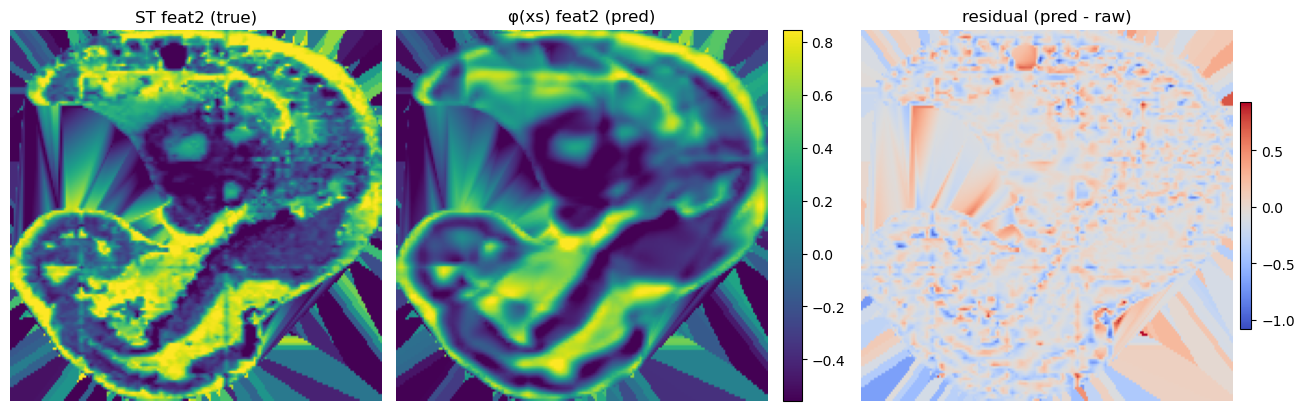

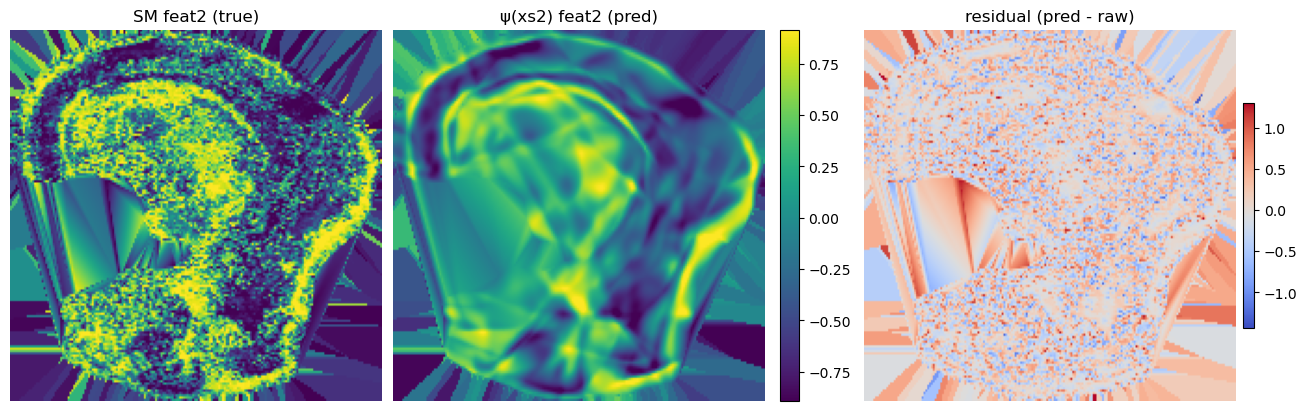

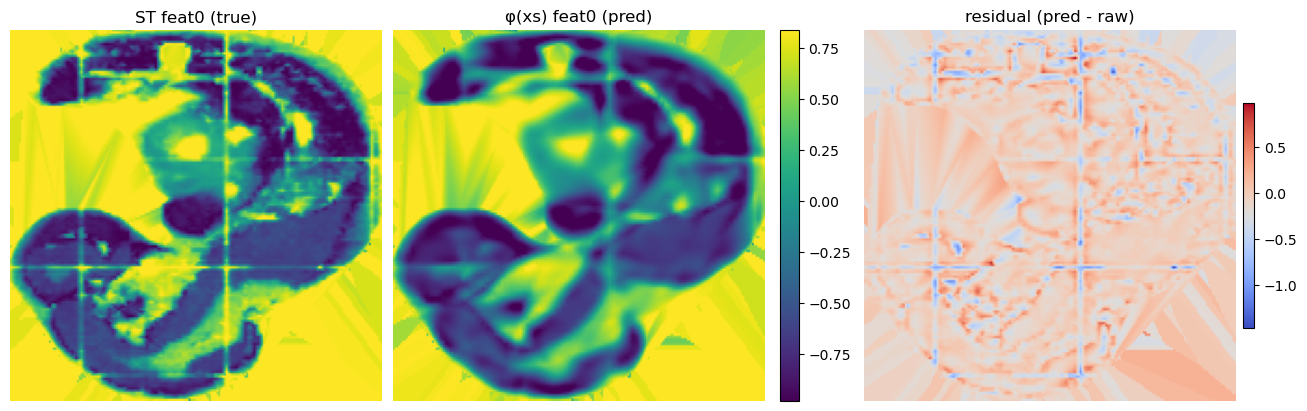

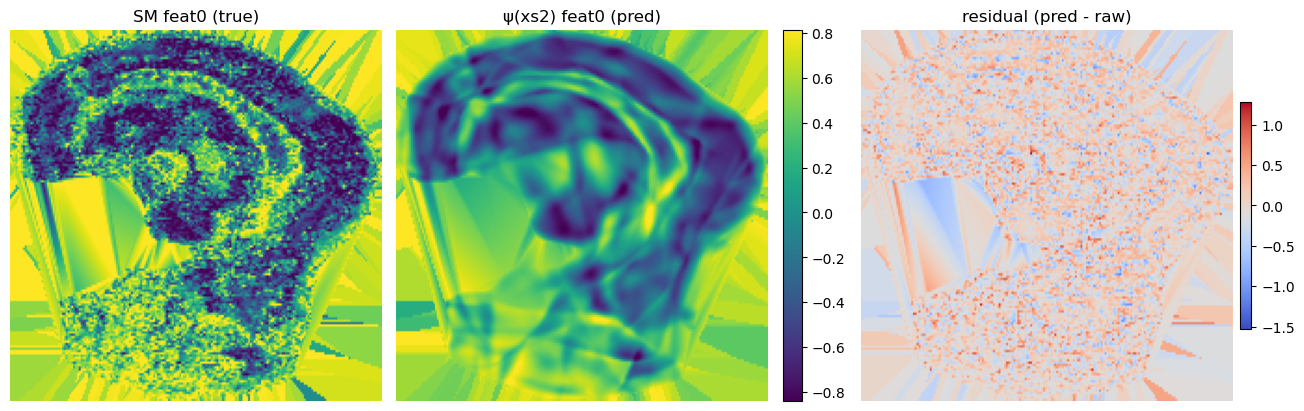

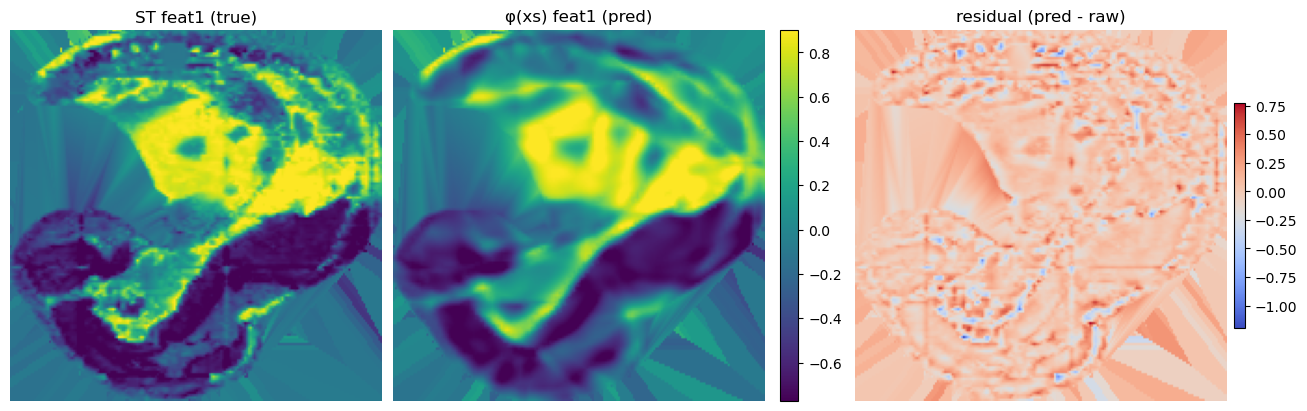

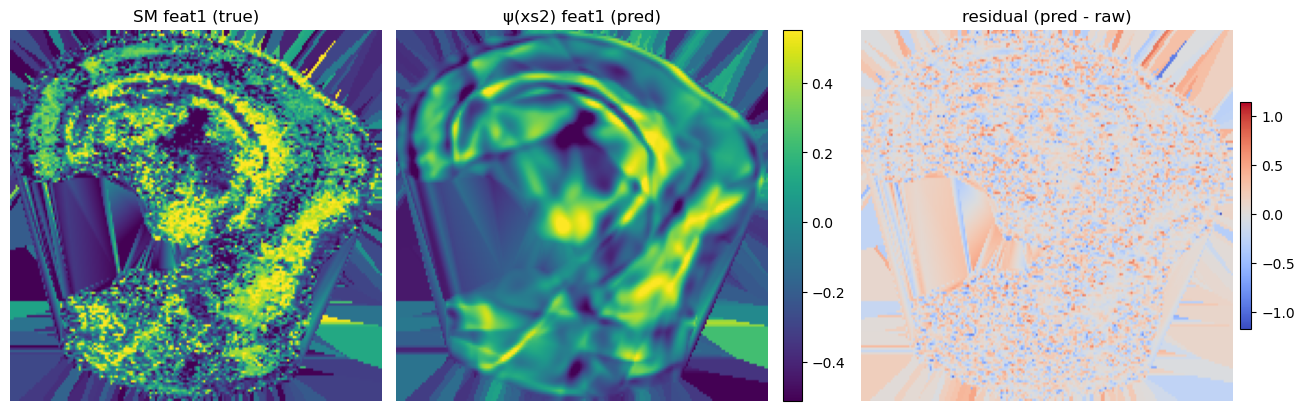

[mgw.core] pullback metrics & geodesics
Rescaling Jacobians by 473.6907535789369.
Rescaling Jacobians by 392.78377800367315.
[mgw.core] solving GW with {'verbose': True, 'inner_maxit': 3000, 'outer_maxit': 3000, 'inner_tol': 1e-07, 'outer_tol': 1e-07, 'epsilon': 0.0001}
[mgw.core] coupling: shape=(5913, 18408), mass=0.999984


In [17]:

out = mgw.mgw_align_core(
        pre,
        widths=PHI_ARC,
        lr=DEFAULT_LR,
        niter=DEFAULT_ITER,
        knn_k=KNN_K,
        geodesic_eps=DEFAULT_EPS,
        save_dir=EXP_PATH, 
        tag=EXP_TAG, 
        verbose=True,
        plot_net=True, # visually check if the two modalities shown similar pattern
        gw_params = DEFAULT_GW_PARAMS
    )


# We can plot the associated alignment after rigid-transformation into a common frame with Procrustes.

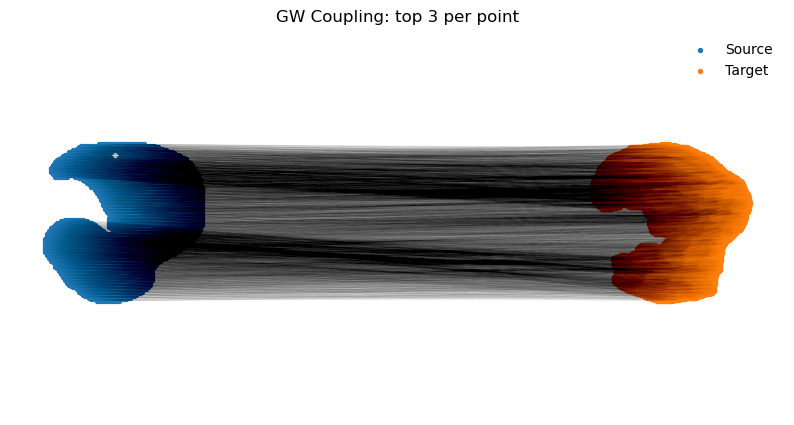

In [21]:

xs = out["xs"]
xs2 = out["xs2"]
P = out["P"]
xs_aligned, xt_aligned, R, tvec = plotting.procrustes_from_coupling(xs, xs2, P)
plotting.plot_alignment_lines_dense(xs, xs2, P, alpha=0.01)


# One can also project the annotations through the alignment to find the `mgw` predicted clusters.

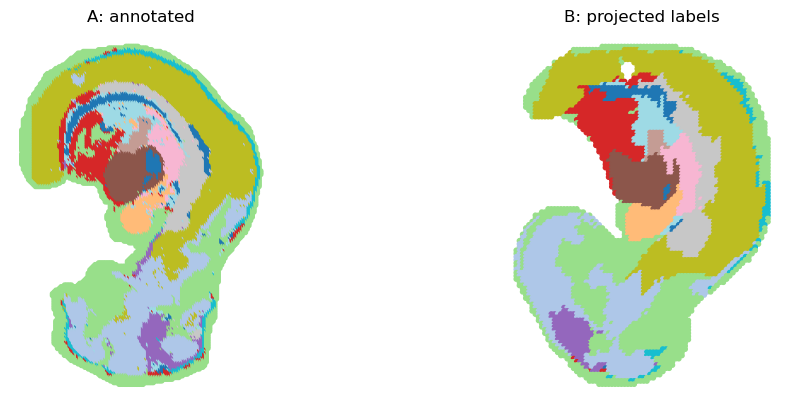

In [24]:

A_labels = plotting._labels_or_cluster(A, key="annotation")
B_labels = plotting._labels_or_cluster(B, key="annotation")

A_pred, A_conf, _ = plotting.project_labels_via_P(P.T, B_labels, direction="A_to_B")
plotting.plot_projected_labels(B.obsm['spatial'], A.obsm['spatial'],
                                  B_labels, A_pred, conf_thresh=0.5, s=10)
